In [ ]:
# Exploring session start times relative to player age
session_start_vs_time <- merged_data |>
    ggplot(aes(x = (hour(start_time) + minute(start_time) / 60), y = age)) +
    geom_point(alpha = 0.3) +
    labs(
        x = "Session Start Time (24h format)",
        y = "Age of players",
        title = "Session Start Times vs Time of Day"
    )


In [ ]:
# Exploring the total users active on the server over a 24 hour period. Idea: Seperate over unique days?

# Get time boundaries
boundaries <- merged_data |>
    summarize(oldest = min(start_time), newest = max(start_time))

# Clean data (we only need the session times)
time_data <- merged_data |>
    select(start_time, end_time) |>
    na.omit()


In [ ]:
# Create a sequence of every minute the server was active
time_seq <- seq(boundaries$oldest, boundaries$newest, "min")

# Count active players for each minute
activity_by_min <- tibble(time = time_seq) |>
    rowwise() |>
    mutate(
        count = sum(time_data$start_time <= time & time_data$end_time > time)
    )

activity_plot_data <- activity_by_min |>
    mutate(
        day_of_week = wday(time, label = TRUE, abbr = FALSE),
        time_clock = (hour(time) + minute(time) / 60)
    ) |>
    group_by(day_of_week, time_clock) |>
    mutate(count = mean(count))


In [ ]:
options(repr.plot.width = 12)
daily_activity_plot <- activity_plot_data |>
    ggplot(aes(x = time_clock, y = count)) +
    geom_line(aes(color = count)) +
    # geom_smooth(method = "lm", formula = y ~ poly(x,18), color="black") +
    facet_grid(rows = vars(day_of_week)) +
    labs(x = "Time of day (24h format)", y = "Average number of players", title = "Average number of players throughout the day (24h format)", colour = "Average number of players")


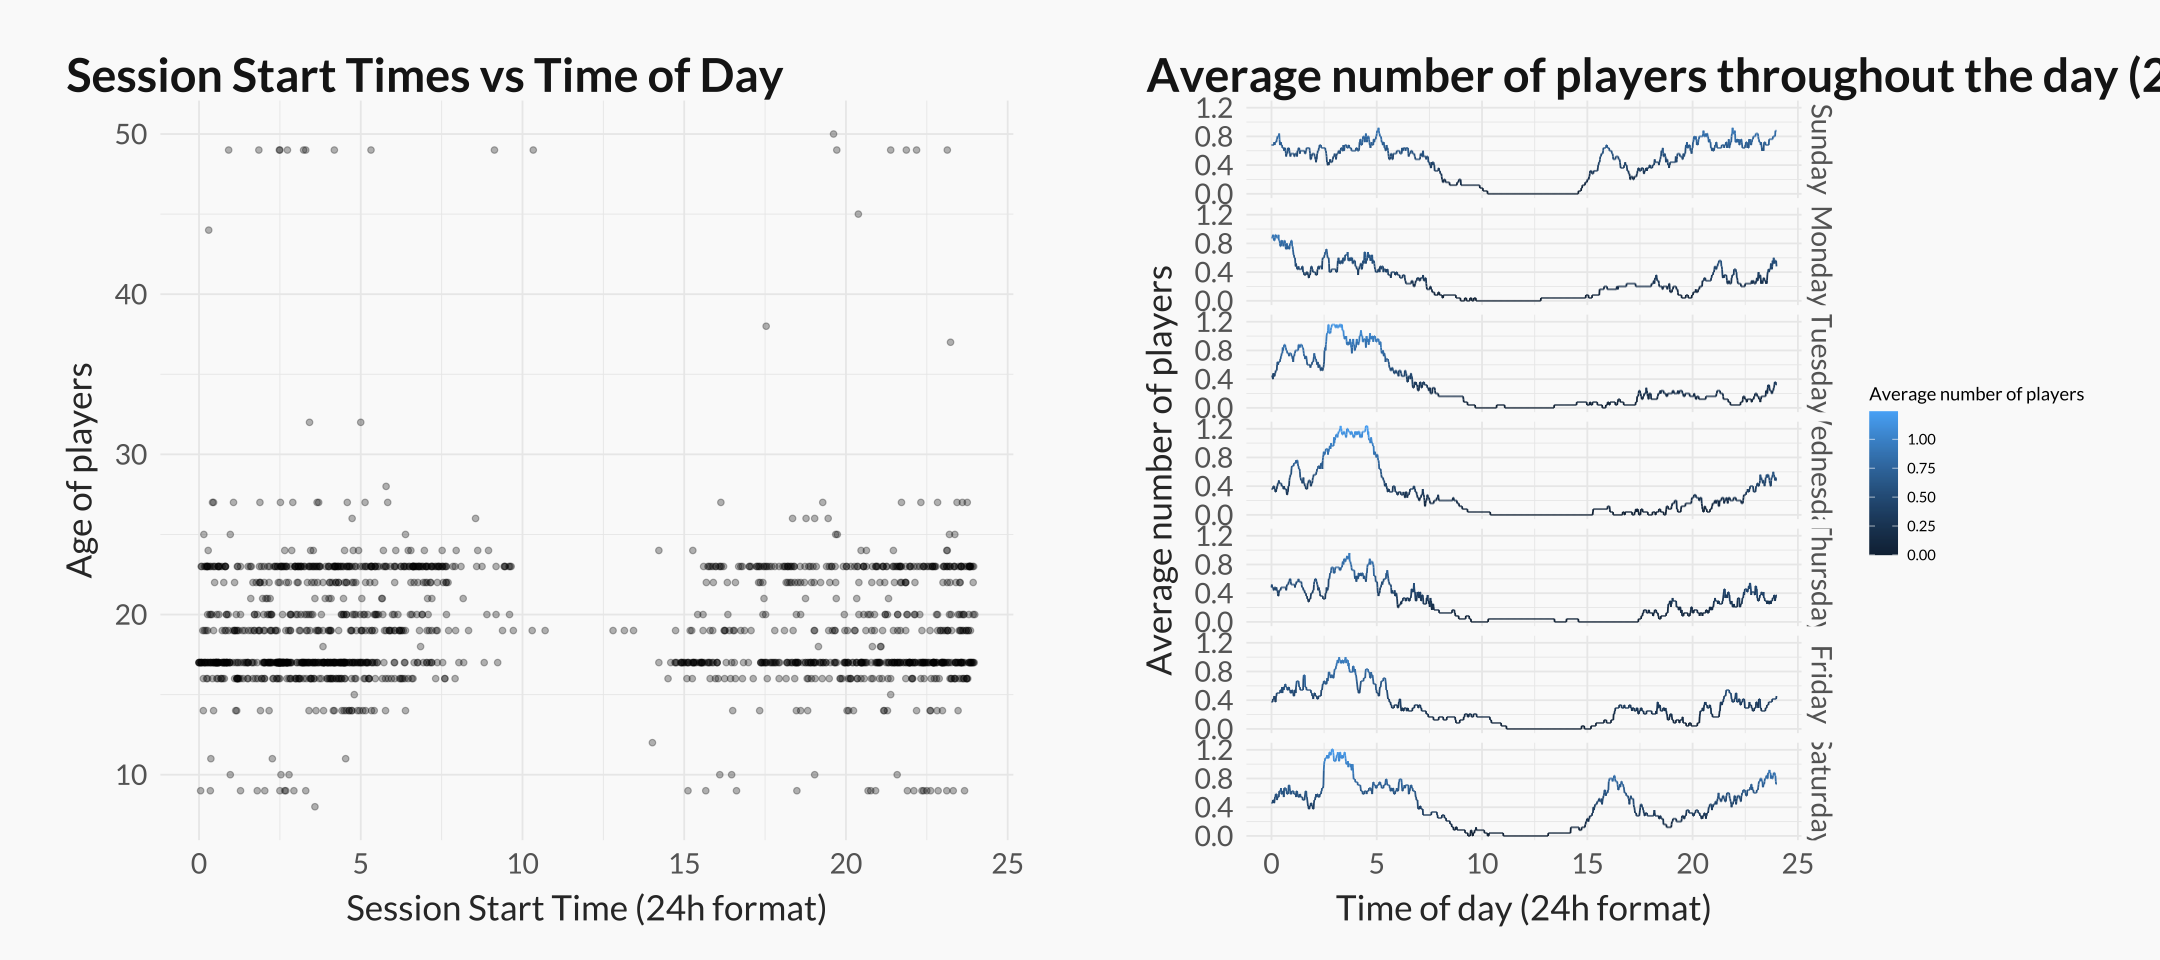

In [ ]:
options(repr.plot.width = 18, repr.plot.height = 8)
final_plot <- grid.arrange(session_start_vs_time, daily_activity_plot, ncol = 2)
